# Code to optimize

```python
for i in tqdm(range(ngs[0] - 1)):
    for j in range(ngs[1] - 1):
        for k in range(ngs[2] - 1):
            if np.absolute(efield[i,j,k] - efield[i+1, j+1, k+1]) <= cv:
                # if efield[i,j,k] - efield[i + 1, j + 1, k + 1] <= cv:
                vacuum.append(efield[i,j,k])
                v += 1
            else:
                non_vacuum.append(efield[i,j,k])
                nvac_ijk.append([i, j, k])
                n += 1
            if (n+v) == 1:
                surface.append(efield[i,j,k])
                surf_ijk.append([i, j, k])
                sarea += mk
            elif v == 2 or n == 2:
                v = 0
                n = 0
```

# First `if-else` condition

```python
if np.absolute(efield[i,j,k] - efield[i+1, j+1, k+1]) <= cv:
    # if efield[i,j,k] - efield[i + 1, j + 1, k + 1] <= cv:
    vacuum.append(efield[i,j,k])
    v += 1
else:
    non_vacuum.append(efield[i,j,k])
    nvac_ijk.append([i, j, k])
    n += 1
```

* `efield` contains the total magnitude of the gradient of 
  the electric field at each voxel.
* Go through every index, `efield[i, j, k]` and compare to 
  `efield[i+1, j+1, k+1]`. Check if difference between 
  these values is smaller than `cv`. This implies the 
  electric field is at vacuum level, because the change 
  in gradient is sufficiently small.
* Note that the last index of `efield[i, j, k]` is not 
  compared to anything, but we *could*, in theory compare it 
  to 0 so that we do not reduce the shape of the `efield` matrix.
* Note that we are only comparing to `i+1, j+1, k+1`, do we wanna
  compare to all neighbors?
  
We can can do this comparison element wise:

In [37]:
import numpy as np
import arrays

## Use views to compare offsets element-wise

In [124]:
a = np.arange(49)
a.resize((7, 7))
a

array([[ 0,  1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12, 13],
       [14, 15, 16, 17, 18, 19, 20],
       [21, 22, 23, 24, 25, 26, 27],
       [28, 29, 30, 31, 32, 33, 34],
       [35, 36, 37, 38, 39, 40, 41],
       [42, 43, 44, 45, 46, 47, 48]])

In [125]:
# View only some of the data
view_a = a[:-1, :-1]
view_a

array([[ 0,  1,  2,  3,  4,  5],
       [ 7,  8,  9, 10, 11, 12],
       [14, 15, 16, 17, 18, 19],
       [21, 22, 23, 24, 25, 26],
       [28, 29, 30, 31, 32, 33],
       [35, 36, 37, 38, 39, 40]])

In [126]:
# View  a shifted subset of the data
view_b = a[1:, 1:]
view_b

array([[ 8,  9, 10, 11, 12, 13],
       [15, 16, 17, 18, 19, 20],
       [22, 23, 24, 25, 26, 27],
       [29, 30, 31, 32, 33, 34],
       [36, 37, 38, 39, 40, 41],
       [43, 44, 45, 46, 47, 48]])

In [128]:
diff = view_a - view_b
diff

array([[-8, -8, -8, -8, -8, -8],
       [-8, -8, -8, -8, -8, -8],
       [-8, -8, -8, -8, -8, -8],
       [-8, -8, -8, -8, -8, -8],
       [-8, -8, -8, -8, -8, -8],
       [-8, -8, -8, -8, -8, -8]])

In [115]:
np.absolute(diff, out=diff)
diff

array([[8, 8, 8, 8, 8, 8],
       [8, 8, 8, 8, 8, 8],
       [8, 8, 8, 8, 8, 8],
       [8, 8, 8, 8, 8, 8],
       [8, 8, 8, 8, 8, 8],
       [8, 8, 8, 8, 8, 8]])

In [114]:
# We can check do the comparison element wise too
diff < 9

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [61]:
diff < 3

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

We can use these as a mask to get all the values of the electric 
field where the there is a vacuum

In [119]:
view_a[diff == 1]

array([], dtype=int64)

In [120]:
view_a[diff != 1]

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18,
       19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38,
       39, 40])

We can save this as a mask array

In [121]:
mask = diff < 9
mask

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [122]:
# and manipulate the mask element-wise
np.logical_not(mask)

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [123]:
# Find the indices where values are True
np.argwhere(mask)

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [0, 5],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5],
       [2, 0],
       [2, 1],
       [2, 2],
       [2, 3],
       [2, 4],
       [2, 5],
       [3, 0],
       [3, 1],
       [3, 2],
       [3, 3],
       [3, 4],
       [3, 5],
       [4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [4, 4],
       [4, 5],
       [5, 0],
       [5, 1],
       [5, 2],
       [5, 3],
       [5, 4],
       [5, 5]])

In [35]:
np.argwhere(np.logical_not(mask))

array([], shape=(0, 2), dtype=int64)

Translation of the first if condition is therefore

```python
efield_view = efield[:-1, :-1, :-1]
efield_diff = efield_view - efield[1:, 1:, 1:]
np.absolute(efield_diff, out=efield_diff)
is_vacuum = efield_diff < cv
is_non_vacuum = np.logical_not(is_vacuum)
vacuum = efield_view[is_vacuum]
non_vacuum = efield_view[is_non_vacuum]
nvac_ijk = np.argwhere(is_non_vaccum)
```

# Second `if-elif` condition

```python
if np.absolute(efield[i,j,k] - efield[i+1, j+1, k+1]) <= cv:
    # if efield[i,j,k] - efield[i + 1, j + 1, k + 1] <= cv:
    vacuum.append(efield[i,j,k])
    v += 1
else:
    non_vacuum.append(efield[i,j,k])
    nvac_ijk.append([i, j, k])
    n += 1
if (n+v) == 1:
    surface.append(efield[i,j,k])
    surf_ijk.append([i, j, k])
    sarea += mk
elif v == 2 or n == 2:
    v = 0
    n = 0
```

* iteration 1: 
  
  * `v == 1`, `n == 0`, `(n + v) == 1`
  * Add value of voxel to surface and increment surface area
  
* iteration 2:
 
  * `v == 1`, `n == 1` `(n + v) == 2`
  * Nothing happens, voxel already accounted for
  
* iteration 3:

  * No increment to surface area
  * Either `n` or `v` will become 2, which means iteration cycle resets
  


## Can we change perspective?

In [64]:
circle = arrays.circle(
    size_x=9,
    size_y=9,
    origin_x=4,
    origin_y=4,
    radius=2,
)
circle

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

In [92]:
is_non_vacuum = circle.view(bool)
is_non_vacuum

array([[False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False,  True, False, False, False, False],
       [False, False, False,  True,  True,  True, False, False, False],
       [False, False,  True,  True,  True,  True,  True, False, False],
       [False, False, False,  True,  True,  True, False, False, False],
       [False, False, False, False,  True, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False]])

In [93]:
is_vacuum = np.logical_not(is_vacuum)
is_vacuum

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True, False,  True,  True,  True,  True],
       [ True,  True,  True, False, False, False,  True,  True,  True],
       [ True,  True, False, False, False, False, False,  True,  True],
       [ True,  True,  True, False, False, False,  True,  True,  True],
       [ True,  True,  True,  True, False,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True]])

In [94]:
is_non_vacuum.view(np.int8)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

In [97]:
is_vacuum.view(np.int8)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 0, 0, 0, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int8)


In order to get the surface, for a given element:

* If I am not-vacuum and and any of my neighbors is a vacuum, I am on the surface

Setting a value based on the values of your neighbors is kind of like a convolution operation:

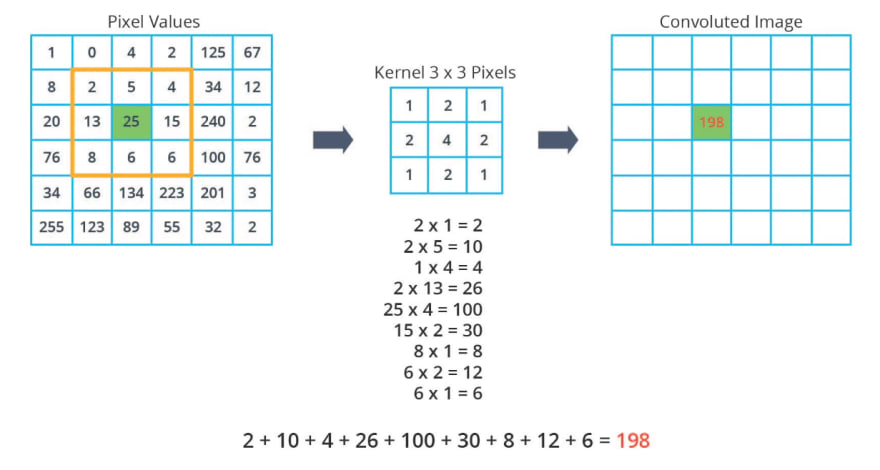

Image credit: https://dev.to/sandeepbalachandran/machine-learning-convolution-with-color-images-2p41

Can we pick a kernel and a set of inputs, so that only the surface voxels have a non-zero value?

What we want:

Start with an input of the following form


```python

input = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1, 1, 1],
    [1, 1, 1, 0, 0, 0, 1, 1, 1],
    [1, 1, 0, 0, 0, 0, 0, 1, 1],
    [1, 1, 1, 0, 0, 0, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1],
]
```

Any convolution, which centered on a non-vacuum element and neighbors a vacuum element should be greater than 0. Ok, so assume an input matrix of the above form, where the 1 is set for all vacuum voxels


take a cutout of the grid, centered on a non-vacuum voxel (ie one with a value of 0), which is on the surface

```python
input = [
    [1, 1, 0],
    [1, 0, 0],
    [0, 0, 0],
]
```

The sum of all elements for a cutout centered on a surface voxel, should be greater than 0.

take a cutout of the grid, centered on a non-vacuum voxel (ie one with a value of 0), which is not on the surface, (ie, all neighbors are 0 too)

```python
input = [
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
]
```

The sum of all elements for a coutout centered on a non-surface voxel should be 0. 

These results can be achieved by a convlution with the following weights

```python
weights = [
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1],
]
```

Lets say we take a cutout of the grid, cenetered on a non-vaccum voxel, which we may decide is not on the surface, because only diagonal elements are vacuum 

```python
input = [
    [1, 0, 1],
    [0, 0, 0],
    [1, 0, 1],
]
```

The sum of all elements after the convolution here should also be 0, if we decide this is not a surface voxel. we can use a kernel of the following form

```python
weights = [
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0],
]
```

A example convolution, for a surface voxel, will be

```python
weights = [
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0],
]
input = [
    [1, 1, 0],
    [1, 0, 0],
    [0, 0, 0],
]
product = [
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 0],
]
convolution = sum(product) = 2
```

an example convolution for a non-surface voxel will be

```python
weights = [
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0],
]
input = [
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
]
product = [
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
]
convolution = sum(product) = 0
```

or

```python
weights = [
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0],
]
input = [
    [1, 0, 1],
    [0, 0, 0],
    [1, 0, 1],
]
product = [
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
]
convolution = sum(product) = 0
```


We also want the sum of any convolution, which starts on an vacuum-element to be 0. Easy, the result of any convolution which started at such an element is simply multiplied by 0. `np.multiply(convolution_result, is_non_vacuum.view(np.int8), out=convolution_result)`.

Using `scipy` we can do this

```python
convolution_result = scipy.ndimage.convolve(
    input=is_vacuum.view(np.int8),
    weights=[
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0],
    ],
    mode='constant',
)
np.multiply(convolution_result, is_non_vacuum.view(np.int8), out=convolution_result)
```


In [98]:
is_vacuum.view(np.int8)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 0, 0, 0, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int8)

In [99]:
import scipy.ndimage

convolution_result = scipy.ndimage.convolve(
    input=is_vacuum.view(np.int8),
    weights=[
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0],
    ],
    mode='constant',
    cval=1,
)
np.multiply(convolution_result, is_non_vacuum.view(np.int8), out=convolution_result)
convolution_result

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 2, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 2, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

In [100]:
surface_mask = convolution_result > 0
surface_mask.view(np.int8)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

In [101]:
surface_mask

array([[False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False,  True, False, False, False, False],
       [False, False, False,  True, False,  True, False, False, False],
       [False, False,  True, False, False, False,  True, False, False],
       [False, False, False,  True, False,  True, False, False, False],
       [False, False, False, False,  True, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False]])

In [102]:
np.sum(surface_mask)

8

Optimized code:

```python
surface = efield_view[surface_mask]
surface_ijk = np.argwhere(surface_mask)
sarea = np.sum(surface_mask) * mk
```